In [1]:
import numpy as np
import ipdb # for debugging
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse


In [2]:
def plot_ellipse(mean, cov_matrix,color, axes, scale_factor=1):
    eH = np.array(None)
    cov_matrix = cov_matrix[:2,:2]
    mean = mean[0:2]
    if(~any(np.diag(cov_matrix)==0)):
        eig_values, eig_vectors = np.linalg.eig(cov_matrix)
        ellipse = Ellipse(xy=mean, width=eig_values[0]*scale_factor, height=eig_values[1]*scale_factor,
                         angle=np.rad2deg(np.arccos(eig_vectors[0,0])), color='black')
        axes.add_artist(ellipse)
        ellipse.set_clip_box(axes.bbox)
        ellipse.set_facecolor('None')
        ellipse.set_edgecolor(color)

In [3]:
def draw_robot(Xr, col, fig):
    p = 0.04
    a = np.array([-2, 10, -2, 10])
    l1 = (a[1] - a[0]) * p
    l2 = (a[3] - a[2]) * p
    P = np.array([[-1, 1, 0, -1], [-1, -1, 3, -1]])
    theta = Xr[2] - np.pi/2
    c = np.cos(theta)[0]
    s = np.sin(theta)[0]
    rot_mat = np.array([[c, -s], [s, c]])
    P = np.matmul(rot_mat, P)
    P[0] = P[0] * l1 + Xr[0]
    P[1] = P[1] * l2 + Xr[1]
    fig.plot(P[0,:],P[1,:], col, linewidth=1);
    fig.plot(Xr[0], Xr[1], '+' + col);
    

In [10]:
def differential_motion_velocity():
    dT = 0.1
    v = 1
    l = 0.5
    sigmaV = 0.1
    sigmaW = 0.1
    nSteps = 400
    x = np.array([[0],[0],[0]])
    xtrue = x;
    P = np.diag([0.2, 0.4, 0])
    Q = np.diag([sigmaV**2, sigmaW**2])
    
    fig = plt.figure(figsize=(20,10))
    axes = fig.add_subplot(231)
    plt.title = 'Differential Drive model'
    plt.xlim = 50
    for k in range(nSteps):
        w = np.pi / 10 * np.sin(4*np.pi*k/nSteps)
        sx = np.sin(x[2])[0]
        cx = np.cos(x[2])[0]
        si = np.sin(w*dT)
        ci = np.cos(w*dT)
        u = np.array([[v], [w]])

        if (w == 0):
            jac_fx = np.array([[1, 0, -v*dT*sx],
                              [0, 1, v*dT*cx],
                              [0, 0, 1]])
            jac_fu = np.array([[dT*cx, dT*sx, 0],
                              [0, 0, 0]]).T
        else:
            R = v/w
            
            jac_fx = np.array([[1, 0, R*(-sx*si - cx*(1-ci))],
                              [0, 1, R*(cx*si - sx*(1-ci))],
                              [0, 0, 1]])
            _jac_fu1 = np.array([[cx*si - sx*(1-ci), R*(cx*ci - sx*si)],
                                 [sx*si + cx*(1-ci), R*(sx*ci - cx*si)],
                                  [0, 1]])
            _jac_fu2 = np.array([[1/w, -v/(w**2)],
                                 [0, dT]])
            jac_fu = np.matmul(_jac_fu1, _jac_fu2)
            
        _P1 = np.matmul(np.matmul(jac_fx,P),jac_fx.T)
        _P2 = np.matmul(np.matmul(jac_fu, Q), jac_fu.T)
        P =  _P1 + _P2
        xtrue = differential_model(xtrue,u+np.array([[sigmaV], [sigmaW]])*np.random.randn(2,1), dT);
        x = differential_model(x,np.array([[v],[w]]),dT);    
        if(np.mod(k-1,20) == 0):
            draw_robot(x,'r', axes);  
            plot_ellipse(x,P,'red', axes, 1);
            plt.plot(xtrue[0],xtrue[1],'ko');

In [11]:
def differential_model(x, u, dT): 
    y = np.zeros([3, 1])
    if(u[1]== 0):
        y[0,0] = x[0] + u[0]*dT*np.cos(x[2])[0]
        y[1,0] = x[1] + u[0]*dT*np.sin(x[2])[0]
        y[2,0] = x[2];
    else:
        R=u[0]/u[1]
        y[0,0] = x[0] - R*np.sin(x[2])[0] + R*np.sin(x[2]+u[1]*dT)[0]
        y[1,0] = x[1] + R*np.cos(x[2])[0] - R*np.cos(x[2]+u[1]*dT)[0]
        y[2,0] = x[2] + u[1]*dT;
    return y

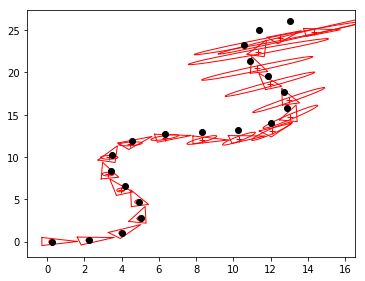

In [24]:
differential_motion_velocity()